In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 28 2024

@author: Yaning
"""

import torch
import pyro
import math
import pandas as pd
from pyro.distributions import Normal, Bernoulli, Gamma, Exponential
import torch.distributions.constraints as constraints
from pyro.distributions.util import scalar_like
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.util import initialize_model, summary
from pyro.util import ignore_experimental_warning
from pyro import poutine
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.parallel import DataParallel
import graphviz


%run Documents/pyro_models/files_to_run/data_analysis_without_version.ipynb


/tmp/ipykernel_1091780/286200100.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


['', 'trial', 'val_basic', 'delay', 'val_prc', 'response', 'RT', 'respSide', 'sideNOW', 'Version', 'loopID', 'Context']


In [2]:
test_data = data[:,:2]

In [3]:
test_data = torch.tensor(test_data)

In [4]:
test_data.shape

torch.Size([2, 2, 170, 8])

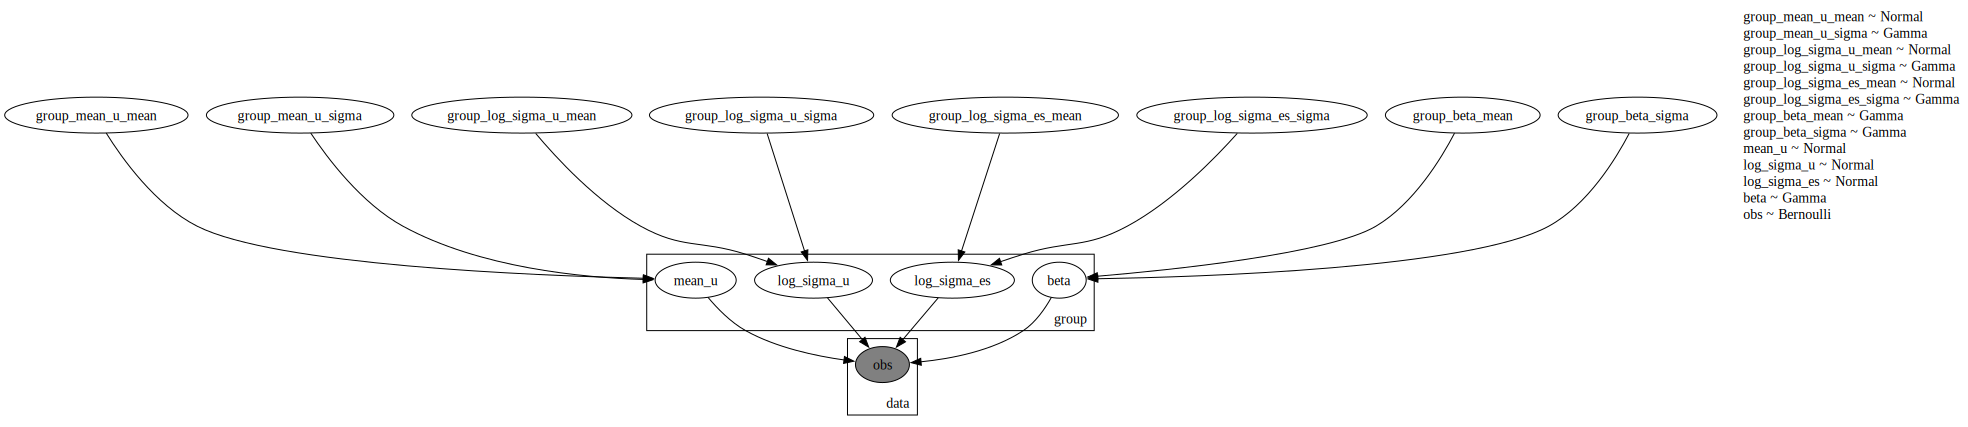

In [30]:
# MCMC model

def model(data):
    num_groups = data.shape[0]
    num_trials_per_group = data.shape[1]

    group_mean_u_mean = pyro.sample("group_mean_u_mean", Normal(loc = torch.tensor(0.), scale = torch.tensor(2.)))
    group_mean_u_sigma = pyro.sample("group_mean_u_sigma", Gamma(torch.tensor(1.), torch.tensor(2.)))
    group_log_sigma_u_mean = pyro.sample("group_log_sigma_u_mean", Normal(torch.tensor(1.), torch.tensor(2.)))
    group_log_sigma_u_sigma = pyro.sample("group_log_sigma_u_sigma", Gamma(torch.tensor(1.), torch.tensor(2.)))
    group_log_sigma_es_mean = pyro.sample("group_log_sigma_es_mean", Normal(torch.tensor(1.), torch.tensor(2.)))
    group_log_sigma_es_sigma = pyro.sample("group_log_sigma_es_sigma", Gamma(torch.tensor(1.), torch.tensor(2.)))
    group_beta_mean = pyro.sample("group_beta_mean", Gamma(torch.tensor(1.), torch.tensor(2.)))
    group_beta_sigma = pyro.sample("group_beta_sigma", Gamma(torch.tensor(1.), torch.tensor(2.)))
    group_time_a_mean = pyro.sample("group_time_a_mean", Gamma(torch.tensor(1.), torch.tensor(2.)))
    group_time_a_sigma = pyro.sample("group_time_a_sigma", Gamma(torch.tensor(1.), torch.tensor(2.)))
    group_time_b_mean = pyro.sample("group_time_b_mean", Normal(1., 6.))


    with pyro.plate("group", num_groups):
        mean_u = pyro.sample("mean_u", Normal(group_mean_u_mean, group_mean_u_sigma))
        log_sigma_u = pyro.sample("log_sigma_u", Normal(group_log_sigma_u_mean, group_log_sigma_u_sigma))
        log_sigma_es = pyro.sample("log_sigma_es", Normal(group_log_sigma_es_mean, group_log_sigma_es_sigma))
        beta = pyro.sample("beta", Gamma(group_beta_mean, group_beta_sigma))
        

    group_indices = torch.arange(num_groups).unsqueeze(1).repeat(1, num_trials_per_group).reshape(-1)
    
    with pyro.plate("data", num_groups*num_trials_per_group):
        
        sigma_u = torch.exp(log_sigma_u[group_indices])
        sigma_es = torch.exp(log_sigma_es[group_indices])
        e_val = (mean_u[group_indices]*data[:,:,2].view(-1)*sigma_es**2 + 
                 data[:,:,3].view(-1)*sigma_u**2)/(data[:,:,2].view(-1)*sigma_es**2 + sigma_u**2)
        softmax_args = torch.stack([beta[group_indices]*e_val, beta[group_indices]*data[:,:,1].view(-1)])
        p = torch.softmax(softmax_args, dim = 0)[0]
        pyro.sample("obs", Bernoulli(probs = p), obs=data[:,:,4].view(-1))
            

pyro.render_model(model = model, model_args=(test_data,), render_params=True, render_distributions=True)

In [44]:
model = DataParallel(model)

In [45]:
chain_num = 1
sample_num = 10

# test_data.to('cuda:0')
# Ben's reinforcement learning iteration 60,000 
# burin 45,000
mcmc_kernel = NUTS(model)                                               # initialize proposal distribution kernel
mcmc = MCMC(mcmc_kernel, num_samples=sample_num, num_chains = chain_num, warmup_steps=5)  # initialize MCMC class
mcmc.run(test_data)


Warmup:   0%|                                                                  | 0/15 [00:00, ?it/s]

AttributeError: 'function' object has no attribute 'parameters'

In [35]:
test = mcmc.summary(prob=0.9)


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.69      0.00      0.69      0.69      0.69     10.25      1.00
                   beta[1]      0.49      0.00      0.49      0.49      0.50     10.25      1.00
                   beta[2]      0.41      0.01      0.41      0.41      0.43     10.25      1.00
                   beta[3]      0.59      0.01      0.59      0.59      0.61     10.25      1.00
                   beta[4]      1.24      0.01      1.24      1.24      1.26     10.25      1.00
                   beta[5]     -0.00      0.01     -0.00     -0.03     -0.00     10.25      1.00
                   beta[6]      0.02      0.01      0.03     -0.02      0.03     10.25      1.00
                   beta[7]      0.15      0.00      0.15      0.14      0.15     10.25      1.00
                   beta[8]     -0.04      0.01     -0.04     -0.06     -0.04     10.25      1.00
                   beta[9]   

In [26]:
# save the summary dictionary
# I changed the source code of pyro on summary
torch.save(test, 'tensor_dict.pth')

In [24]:
samples_dict = mcmc.get_samples()

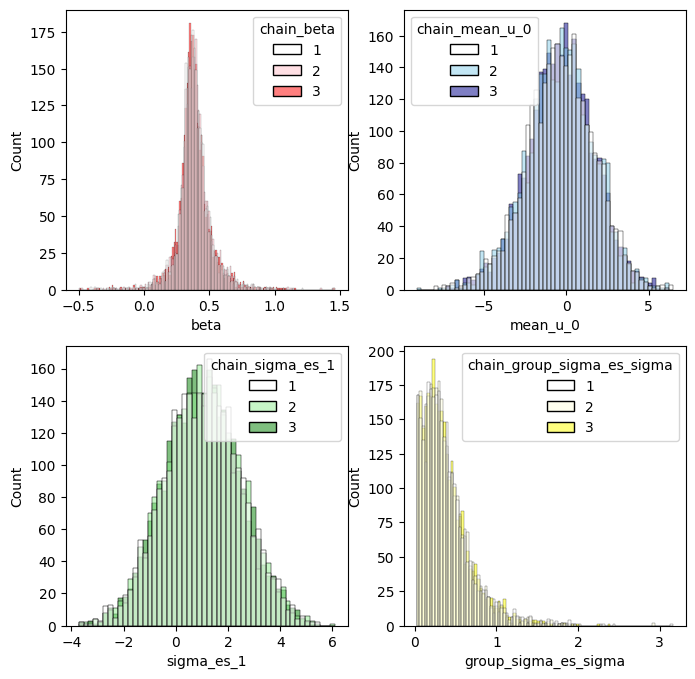

In [23]:
# get posterior with pandas dataframe
# I only sampled some because it is too many
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

beta = pd.DataFrame(mcmc.get_samples()['group_beta_mean'],columns=['beta'])
beta['chain_beta'] = torch.tensor([1,2,3]).repeat(sample_num)
sns.histplot(data=beta, x='beta',hue='chain_beta', palette=['white', 'pink', 'red'], ax=axs[0,0])

mean_u_0 = pd.DataFrame(mcmc.get_samples()['mean_u'][:,0],columns=['mean_u_0'])
mean_u_0['chain_mean_u_0'] = torch.tensor([1,2,3]).repeat(sample_num)
sns.histplot(data=mean_u_0, x='mean_u_0',hue='chain_mean_u_0', palette=['white', 'skyblue', 'darkblue'], ax=axs[0,1])

sigma_es_1 = pd.DataFrame(mcmc.get_samples()['log_sigma_es'][:,1],columns=['sigma_es_1'])
sigma_es_1['chain_sigma_es_1'] = torch.tensor([1,2,3]).repeat(sample_num)
sns.histplot(data=sigma_es_1, x='sigma_es_1',hue='chain_sigma_es_1', palette=['white', 'lightgreen', 'green'], ax=axs[1,0])

group_sigma_es_sigma = pd.DataFrame(mcmc.get_samples()['group_log_sigma_es_sigma'],columns=['group_sigma_es_sigma'])
group_sigma_es_sigma['chain_group_sigma_es_sigma'] = torch.tensor([1,2,3]).repeat(sample_num)
sns.histplot(data=group_sigma_es_sigma, x='group_sigma_es_sigma',hue='chain_group_sigma_es_sigma', palette=['white', 'lightyellow', 'yellow'], ax=axs[1,1])

plt.show()

In [32]:
results = pd.concat([mean_u, log_sigma_u, log_sigma_es, beta], axis=1, join='inner')

In [33]:
results.to_csv('Documents/pyro_models/results/MCMC_mit_log.csv', index=False)